In [158]:
from analysis.analyze_results import *
from pathlib import Path
import matplotlib

In [159]:
# output_base_folder = Path("/Users/che/iarai/work/logs/storage_benchmarking")
# output_base_folder = Path("/iarai/work/logs/storage_benchmarking")
# output_base_folder = Path("/home/ivan/temp/temp-benchmarking")
output_base_folder = Path("/home/ivan/Documents/git/storage-benchmarking/src/benchmark_output")


## Dataloader benchmark

**parameters**

| param | range |
| --- | --- |
| batch_pool_size | 2, 4, 8, 16, 32, 64 | 
| num_fetch_workers | 2, 4, 8, 16, 32, 64, 128 | 
| fetch_impl | asyncio, threaded |
| dataset | s3,scratch |


**parameters explained**

| param | implementation | details | 
| --- | --- | --- |
| batch_pool_size | asyncio | Unused |
|  | threaded | Number of batches to fetch in parallel (normally, one batch is fetched, and items are downloaded (sequentiall or in parallel). This implementation takes N batches, and starts downloading items in parallel. Individual items are yielded and once a full batch is collected it is yielded.)|
| num_fetch_workers | asyncio | ThreadPoolExecutor argument for the maximum number of threads that can be used to execute the given calls. Also, the number of tasks initiall placed into the task (worker) queue.  |
|  | threaded | ThreadPoolExecutor argument for the maximum number of threads that can be used to execute the given calls |

In [160]:
group_by_dataloader = ["dataset",  "num_fetch_workers", "num_workers", "batch_pool"]

In [161]:
df_dataloader = extract_pandas(output_base_folder, folder_filter="*benchmark_e2e*")
# df_dataloader = extract_pandas(output_base_folder, folder_filter="*benchmark_dataloader_s3*")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 41.36it/s]


Let's visualize the timeline of dataloading, a new color for each thread (cycle 8)

In [162]:
df_dataloader_zeroworkers_th=df_dataloader[df_dataloader["num_workers"]==0]
df_dataloader_zeroworkers_th=df_dataloader_zeroworkers_th[df_dataloader_zeroworkers_th["fetch_impl"]=="vanilla"]

In [163]:
display(get_run_stats(df_dataloader_zeroworkers_th, group_by=group_by_dataloader))

,,,,,downloaded data [B],time_start,time_end,total_elpased_time [s],downloaded data [MB],throughput [MBit/s]
dataset,num_fetch_workers,num_workers,batch_pool,run,,,,,,
s3,10,0,10,20210930f222829_benchmark_e2e_s3_4_0_10_sync,113916351.0,1.633034e+09,1.633034e+09,752.441593,113.916351,1.211165


In [164]:
# rate_matrix = np.ndarray(shape=(6,7), dtype=float, order='F')
rate_matrix_threaded = pd.DataFrame(columns=["x", "y", "rate"])

# print(f"Batch pool size: {num_fetch_workers}, {batch_pool_size}")
# run = df_dataloader_zeroworkers_th[(df_dataloader_zeroworkers_th["num_fetch_workers"]==16)]["run"].iloc[0]
# mbps, mbitps = plot_events_timeline(df_dataloader_zeroworkers_th[df_dataloader_zeroworkers_th["run"]==run], summary_only=True)
# if list(mbitps)[0] != "0 Bytes":
#     r = float(list(mbitps)[0].replace("MB", ""))
#     rate_matrix_threaded = rate_matrix_threaded.append({'x': batch_pool_size, 'y': num_fetch_workers, 'rate': r}, ignore_index=True)

# print(rate_matrix_threaded)

In [165]:
print(df_dataloader_zeroworkers_th.keys())

Index(['trace_name', 'trace_level', 'function_name', 'elapsed', 'time_start',
       'time_end', 'process_time', 'process_time_start', 'process_time_end',
       'pid', 'threading_ident', 'global_step', 'len', 'logger',
       'checkpoint_callback', 'default_root_dir', 'gradient_clip_val',
       'gradient_clip_algorithm', 'process_position', 'num_nodes',
       'num_processes', 'devices', 'gpus', 'auto_select_gpus', 'tpu_cores',
       'ipus', 'log_gpu_memory', 'progress_bar_refresh_rate',
       'overfit_batches', 'track_grad_norm', 'check_val_every_n_epoch',
       'fast_dev_run', 'accumulate_grad_batches', 'max_epochs', 'min_epochs',
       'max_steps', 'min_steps', 'max_time', 'limit_train_batches',
       'limit_val_batches', 'limit_test_batches', 'limit_predict_batches',
       'val_check_interval', 'flush_logs_every_n_steps', 'log_every_n_steps',
       'accelerator', 'sync_batchnorm', 'precision', 'weights_summary',
       'weights_save_path', 'num_sanity_val_steps', 'truncate

130


<BarContainer object of 130 artists>

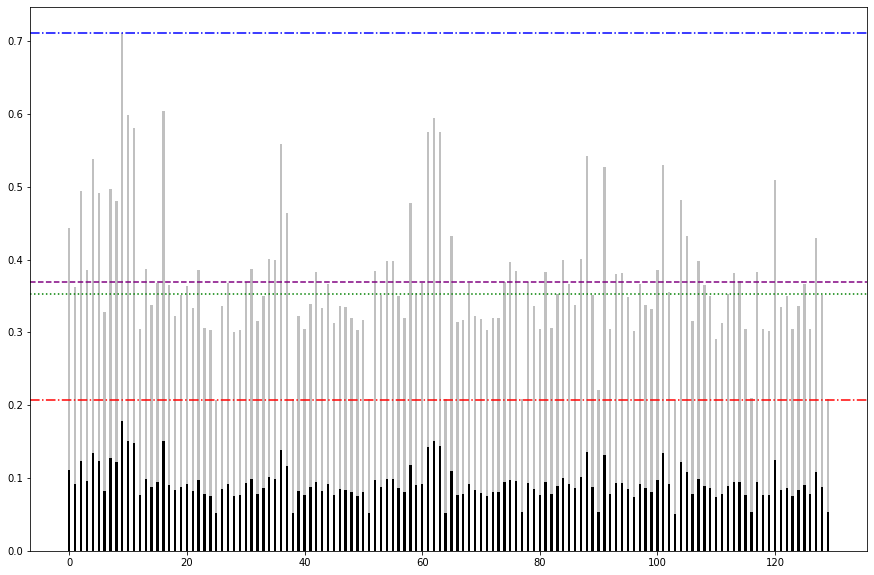

In [166]:
df_step_time = df_dataloader_zeroworkers_th[df_dataloader_zeroworkers_th["trace_name"]=="(6)-training_step"]
# step_time_list = list(df_step_time["process_time"])
step_time_list_process_time = df_step_time["process_time"].to_numpy()
step_time_list_elapsed = df_step_time["elapsed"].to_numpy()
print(len(step_time_list))

fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(x=range(len(step_time_list_process_time)), height=step_time_list_process_time, width=0.4, color="silver")
ax.axhline(step_time_list_process_time.mean(), color='purple', linewidth=1.5, linestyle="--")
ax.axhline(np.median(step_time_list_process_time), color='green', linewidth=1.5, linestyle=":")
ax.axhline(np.min(step_time_list_process_time), color='red', linewidth=1.5, linestyle="-.")
ax.axhline(np.max(step_time_list_process_time), color='blue', linewidth=1.5, linestyle="-.")

ax.bar(x=range(len(step_time_list_elapsed)), height=step_time_list_elapsed, width=0.4, color="black")

# plt.bar(x=range(len(step_time_list)), height=step_time_list, width=0.1)

130


<BarContainer object of 262 artists>

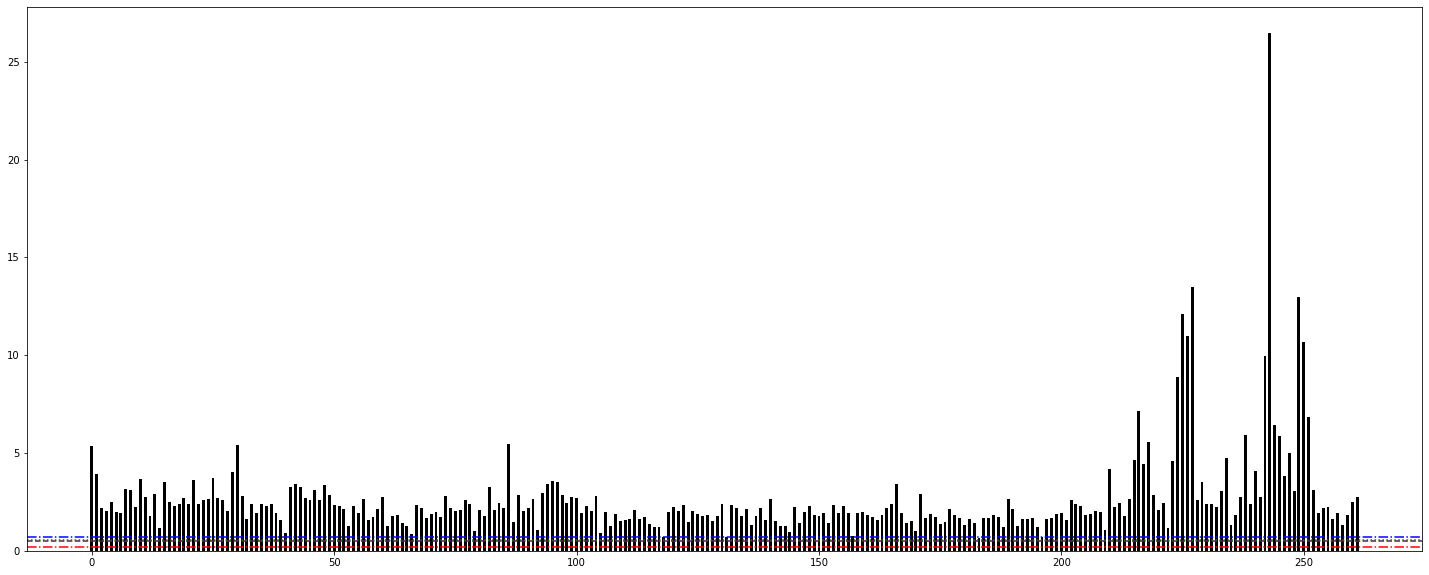

In [167]:
# df_step_time = df_dataloader_zeroworkers_th[df_dataloader_zeroworkers_th["trace_name"]=="(7)-training_step"]
# df_step_time = df_dataloader_zeroworkers_th[df_dataloader_zeroworkers_th["trace_name"]=="(5)-get_item"]
# df_step_time = df_dataloader_zeroworkers_th[df_dataloader_zeroworkers_th["trace_name"]=="(4)-asyncmapdataset-fetcher"]
# df_step_time = df_dataloader_zeroworkers_th[df_dataloader_zeroworkers_th["trace_name"]=="(4)-threadedmapdataset-fetcher"]
df_step_time = df_dataloader_zeroworkers_th[df_dataloader_zeroworkers_th["trace_name"]=="(4)-mapdataset-fetcher"]


step_time_list_process_time = df_step_time["process_time"].to_numpy()
step_time_list_elapsed = df_step_time["elapsed"].to_numpy()
print(len(step_time_list))

fig, ax = plt.subplots(figsize=(25, 10))
ax.bar(x=range(len(step_time_list_process_time)), height=step_time_list_process_time, width=0.6, color="silver")
ax.axhline(step_time_list_process_time.mean(), color='purple', linewidth=1.5, linestyle="--")
ax.axhline(np.median(step_time_list_process_time), color='green', linewidth=1.5, linestyle=":")
ax.axhline(np.min(step_time_list_process_time), color='red', linewidth=1.5, linestyle="-.")
ax.axhline(np.max(step_time_list_process_time), color='blue', linewidth=1.5, linestyle="-.")

ax.bar(x=range(len(step_time_list_elapsed)), height=step_time_list_elapsed, width=0.6, color="black")

### Threaded best run 

In [168]:
import numpy as np
import seaborn as sns
def plot_events_timeline2(df_dataloader, color_column: str = "threading_ident", cycle=11, summary_only=False):
#     df_dataloader = df_dataloader[(df_dataloader["function_name"] == "__getitem__")]
#     print(len(df_dataloader))
#     df_dataloader = df_dataloader[(df_dataloader["process_time"] >= 10.0e-02)]
#     print(len(df_dataloader))

    
    clrz = {}
    x = np.array(list(df_dataloader["threading_ident"]))
    pallete = sns.color_palette(None, len(np.unique(x)))
    for index, t in enumerate(np.unique(x)):
        clrz[t] = pallete[index]
    print(np.unique(x))
#     x = np.array(list(df_dataloader["function_name"]))
#     print(np.unique(x))
#     x = np.array(list(df_dataloader["process_time"]))
#     print(np.unique(x))
    
    df_dataloader = df_dataloader.sort_values(
        ["pid","threading_ident", "process_time"], ascending=[False, False, False]
    ).reset_index(drop=True)
#     print(df_dataloader.info())


#     df_dataloader = df_dataloader.sort_values(["threading_ident","trace_level"], 
#                                               ascending=[False,False]).reset_index(drop=False)
#     df_dataloader = df_dataloader.sort_values(["threading_ident"], ascending=[False])
    

#     df_dataloader = df_dataloader[(df_dataloader["function_name"] == "yield_item")]
    
#     df_dataloader = df_dataloader[(df_dataloader["threading_ident"] == 139630727501568)]
#     print(df_dataloader["function_name"])

#     df_dataloader = df_dataloader.sort_values(
#         ["threading_ident", "time_start"], ascending=[False, False]
#     ).reset_index(drop=True)
#     df_dataloader = df_dataloader.groupby(["threading_ident"])

    dict_dataloader = df_dataloader.to_dict("index")
    
    print(len(dict_dataloader.items()))
#     print(list(dict_dataloader)[:10])

#     dict_dataloader = df_dataloader.groupby('threading_ident').apply(pd.DataFrame).to_dict("index")
#     dict_dataloader = dict_dataloader['threading_ident'].reset_index()
#     dict_dataloader = dict_dataloader.set_index('threading_ident')

    colors = []
    lines = []
    for i, (_, param_series) in enumerate(dict_dataloader.items()):
#         colors.append(clrz[param_series["threading_ident"]])
        lines.append([(param_series["process_time_start"], i), (param_series["process_time_end"], i)])
        if param_series["threading_ident"] == 140133508577024:
            colors.append("black")
        else:
            colors.append("red")

    print(f"Lines num: {len(lines)}")
#     for line in list(lines):
#         d = line[1][0] - line[0][0]
#         if d > 5:
#             lines.remove(line)

    lc = matplotlib.collections.LineCollection(lines, colors=colors, linewidths=3)
    fig, ax = plt.subplots(figsize=(50, 50))
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)


total_elapsed=0:12:32.441593
total_bytes=113.9 MB
overall rate {'151.4 kB'}/s
overall rate {'1.2 MB'}it/s


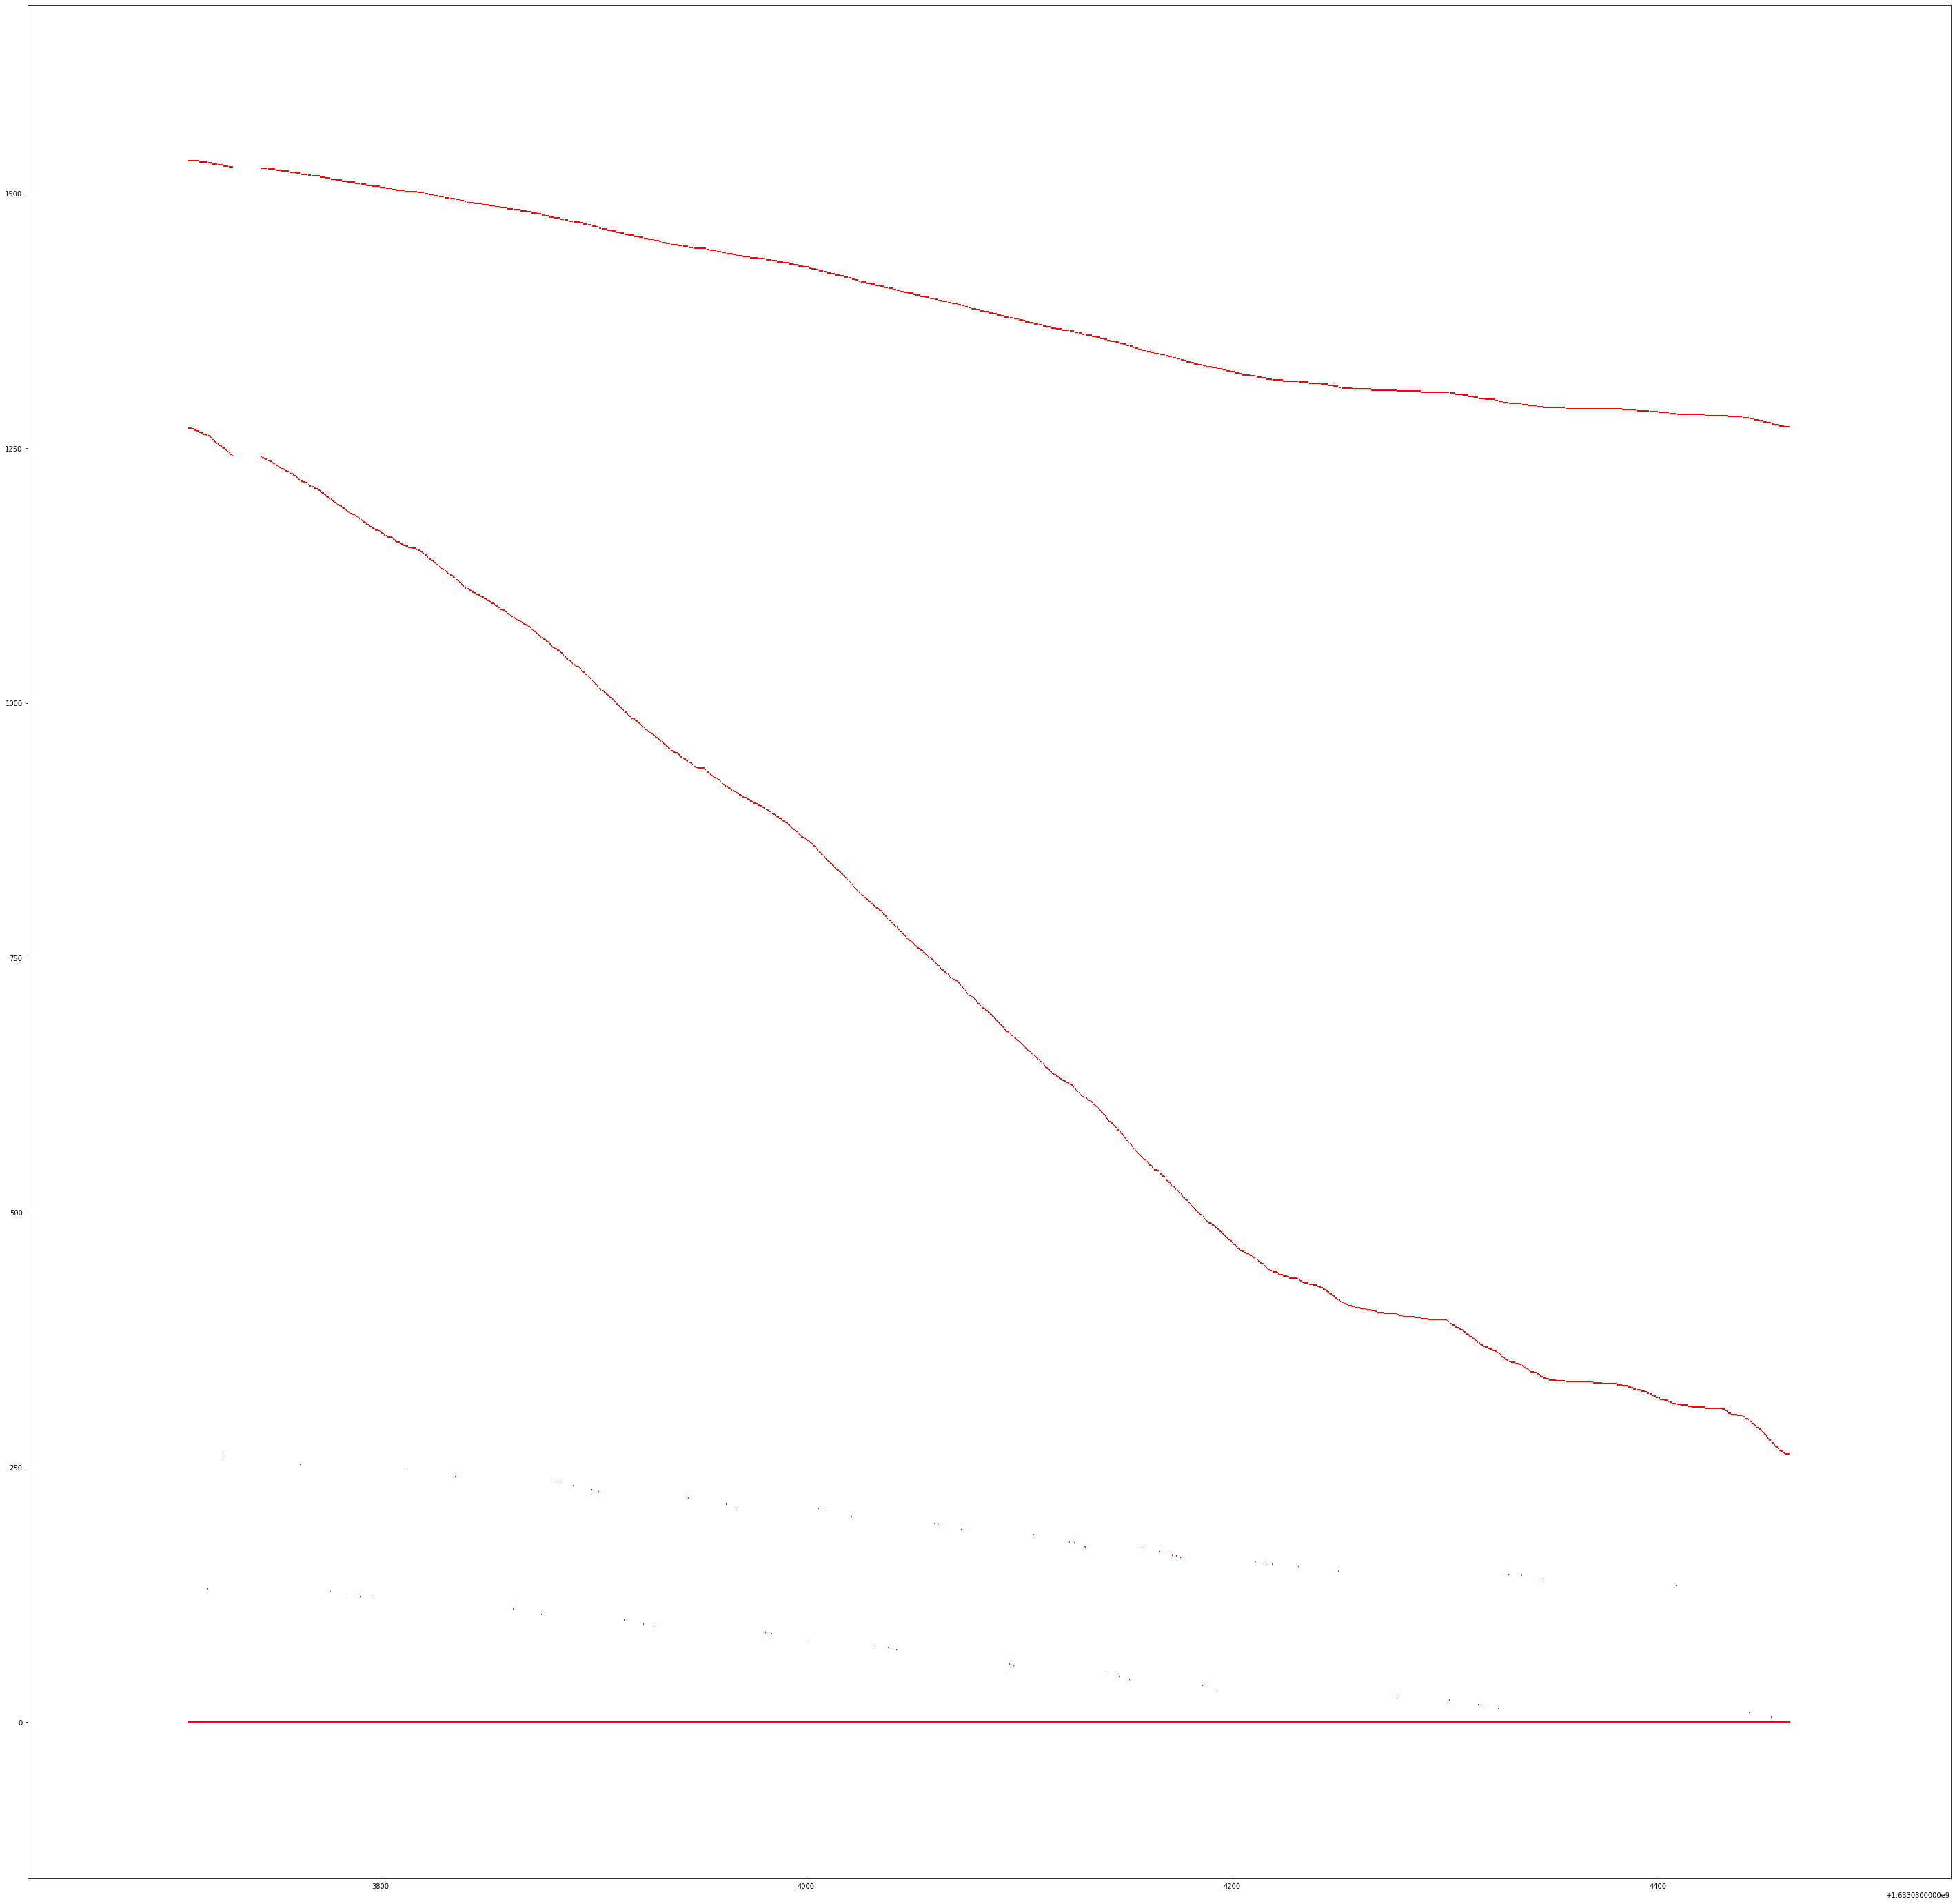

In [169]:
run = df_dataloader_zeroworkers_th[(df_dataloader_zeroworkers_th["num_fetch_workers"]==10)]["run"].iloc[0]
plot_events_timeline(df_dataloader_zeroworkers_th[df_dataloader_zeroworkers_th["run"]==run], summary_only=False)

In [170]:
get_thread_stats(df_dataloader_zeroworkers_th[df_dataloader_zeroworkers_th["run"]==run], group_by=["pid"], trace_level=5)

,time_start_thread,time_end_thread,total_elapsed_thread,pid,elapsed_thread,elapsed_processing
threading_ident,,,,,,
140628420720448,1.633034e+09,1.633034e+09,690.157543,43250,752.194101,0.917526


### Threaded worst run 

In [ ]:
# for i, batch_pool_size in enumerate([2, 4, 8, 16, 32, 64]):
#     for j, num_fetch_workers in enumerate([2, 4, 8, 16, 32, 64, 128]):
run = df_dataloader_zeroworkers_aio[(df_dataloader_zeroworkers_aio["num_fetch_workers"]==4) & (df_dataloader_zeroworkers_aio["batch_pool"]==16)]["run"].iloc[0]
plot_events_timeline2(df_dataloader_zeroworkers_aio[df_dataloader_zeroworkers_aio["run"]==run], summary_only=False)

### Asyncio worst run

In [ ]:
run = df_dataloader_zeroworkers_aio[(df_dataloader_zeroworkers_aio["num_fetch_workers"]==2) & (df_dataloader_zeroworkers_aio["batch_pool"]==2)]["run"].iloc[0]
plot_events_timeline(df_dataloader_zeroworkers_aio[df_dataloader_zeroworkers_aio["run"]==run], summary_only=False)